# Buildingblocks of the model in tensorflow


In [56]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.backend import sum as tf_sum

import seaborn as sns
import time



In [57]:
def tf_lognormal(x, mu, sigma):
    x = tf.clip_by_value(x,1e-12,1e12)
    
    distr = 1/x* tf.math.exp(-((tf.math.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tf_sum(distr, axis=0)+1e-12)

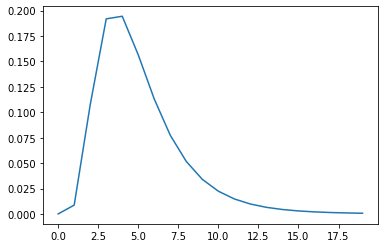

In [58]:
plt.plot(tf_lognormal(np.arange(0,20,dtype=np.float64),tf.math.log(np.array([4.5])),.5))

In [59]:
def SE_serial_model(N, imported_T, R_T, median_serial,sigma_serial,l=10):
    serial_p = tf_lognormal(np.arange(l,dtype=np.float64),np.log(median_serial),sigma_serial)
    
    def imported_day_acc(a,x):
        # unpack:
        E_t1, E_lastv, S_t = a
        R_t,imported_t = x
        # calc
        f = S_t / N
        
        new = imported_t + tf.tensordot(E_lastv, serial_p, 1) * R_t * f  
        E_nextv = tf.concat([new,E_lastv[:-1]],0)
        
        return [new, E_nextv, S_t-new]
    
    initial = [tf.zeros(1,dtype=np.float64),tf.zeros(l,dtype=np.float64),np.array([N])]
    
    r = tf.scan(imported_day_acc,[R_T,imported_T],initial)

    return r

in 0.253s
tf.Tensor([9.26188384], shape=(1,), dtype=float64)


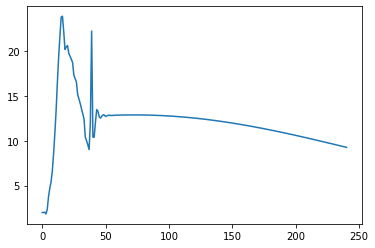

In [60]:
tf.compat.v1.enable_eager_execution()

R_t = np.array([3,3,3,3,3,3,3,3,3,3,3,3,3,2.8,2.5,2.2,1.8,1.4,1.1,1,.95,.9,.9,.9,.9,.85,.85,.85,.8,.8,.8,.8,.8,.8,.7,.7,.7,.7,1,2,1]+[1.01]*200,dtype=np.float64)
R_t = R_t.reshape([R_t.shape[0],1])
imported_t = np.zeros(R_t.shape[0],dtype=np.float64)
imported_t[:4] = np.array([2,2,2,1],dtype=np.float64)
N = np.array([1e5])
N = N.reshape([N.shape[0],1])
N= 1e5

t1 = time.time()
E_t,E_T,S_t = SE_serial_model(N,imported_t,R_t,4.,.44)
t2 = time.time()
    
    
print("in %.3fs"%(t2-t1))

print(E_t[-1])   
plt.plot(E_t)



In [65]:
def GenDummy4cp_AgeGroups(l,age_groups=3):
    #1st day Feb 15 --> March 1st is day 29, 9th is day 38.
    R_0, c_day, c_day_sigma  = 3.,[38,43,52,73],[1,3,2,7]
    c_slope, c_change, c_change_sigma = [3,3,5,7],[-1.,-.75,-.75,1.25],[.25,.25,.1,.5]
    
    R_0_dist = tfp.distributions.Normal(tf.cast(R_0,np.float64),.8)
    R_0s = R_0_dist.sample(age_groups)
    
    day_dist = tfp.distributions.Normal(tf.cast(c_day,np.float64),c_day_sigma)
    days = day_dist.sample(age_groups)
    
    slope_dist = tfp.distributions.LogNormal(tf.math.log(tf.cast(c_slope,np.float64)),.5)
    slopes = slope_dist.sample(age_groups)
    
    change_dist = tfp.distributions.Normal(tf.cast(c_change,np.float64),c_change_sigma)
    changes = change_dist.sample(age_groups)
    
    r = tf.cast((tf.reshape(tf.repeat(tf.range(0,l,1),age_groups),[l,age_groups])),np.float64)
    R_t = tf.ones([l,age_groups],dtype=np.float64)*R_0s
    
    cps = tf.transpose([days,slopes,changes],perm=[2,0,1])
    for day,slope,change in cps:
        s = tf.sigmoid((r-day)/slope)*change
        R_t *= tf.math.exp(s)
    
    R_t = tf.transpose(tf.reshape(R_t,[l,age_groups,1]),perm=[0,2,1])
    # Done generating R_t
    
    imported_t = tf.zeros([l-3,1,age_groups],np.float64)
    front = tf.cast(tf.transpose(tf.reshape([[0,0,0],[1,2,3],[2,1,1],[0,1,2],[0,0,0]][:age_groups],[3,age_groups,1]),perm=[0,2,1]),np.float64)
    imported_t = tf.concat([front,imported_t],axis=0)
    
    return R_t, imported_t

def GenDummyCountries(l,countries,age_groups=5):
    r0,i0 = GenDummy4cp_AgeGroups(l,age_groups)
    for n in range(countries-1):
        r_next,i_next = GenDummy4cp_AgeGroups(l,age_groups)
        r0 = tf.concat([r0,r_next],axis=1)
        i0 = tf.concat([i0,i_next],axis=1)
    return r0,i0

def SE_serial_model_countries_age_groups(N, imported_T, R_T, median_serial,sigma_serial,l=16):
    serial_p = tf_lognormal(np.arange(l,dtype=np.float64),np.log(median_serial),sigma_serial)

    # Calculate fration of each age_group of the total population
    N_sum = tf_sum(N,axis=1)
    Nf = N/tf.reshape(tf.repeat(N_sum,N.shape[1]),N.shape)
    
    def imported_day_acc(a,x):
        # unpack:
        E_t1, E_lastv, S_t = a
        R_t,imported_t = x
       
        # calc susceptible fraction
        f = S_t / N
         
        # Calc "infectious" people, weighted by serial_p (country x age_group)
        infectious = tf.tensordot(E_lastv,serial_p,1)
        t_infectious = tf_sum(infectious,1) # Total infectious per country as pool for new infections
        t2_infectious = tf.reshape(tf.repeat(t_infectious,infectious.shape[1]),infectious.shape) # expand to countries x age_group
        
        # Simple infection:
        R_eff = R_t*f
        R_eff *= Nf
        
      #  new = tf.ones([N.shape[0],N.shape[1]],dtype=np.float64) #imported_t + tf.tensordot(E_lastv, serial_p, 1) * R_t * f  
        new = imported_t + t2_infectious * R_eff
        
        new_v = tf.reshape(new,[new.shape[0],new.shape[1],1])
        E_nextv = tf.concat([new_v,E_lastv[:,:,:-1]], -1 )  # Create new exposed population for new step
        
        return [new, E_nextv, S_t-new]
    
    initial = [tf.zeros(N.shape,dtype=np.float64),tf.zeros([N.shape[0],N.shape[1],l],dtype=np.float64),N]
    
    out = tf.scan(imported_day_acc,[R_T,imported_T],initial)
    return out

def GenNoisyDummyCountries(l,countries,median_serial=4,sigma_serial=.44,age_groups=5,noise=.1):
    """returns the cummulative onsets of symptoms"""
    Ns = tf.ones([n_countries,n_age_groups],np.float64)*1e6
    
    N_dist = tfp.distributions.Normal(tf.cast(1,np.float64),.1)
    N_f = N_dist.sample(Ns.shape)
    Ns *= N_f
    
    R_t,imported_t = GenDummyCountries(l,n_countries,n_age_groups)
    E_t,_,S_t = SE_serial_model_countries_age_groups(Ns,imported_t,R_t,median_serial,sigma_serial)
    
    noise_dist = tfp.distributions.Normal(tf.cast(1,np.float64),.02)
    noise = tf.clip_by_value(noise_dist.sample(E_t.shape),0,1e9)
        
    E_n_t = E_t * noise
    return tf.math.cumsum(E_n_t,axis=0),R_t
    
l,n_countries, n_age_groups = 120,3,4
infected_T,R_T = GenNoisyDummyCountries(l,n_countries,n_age_groups)

Text(0, 0.5, 'R_t')

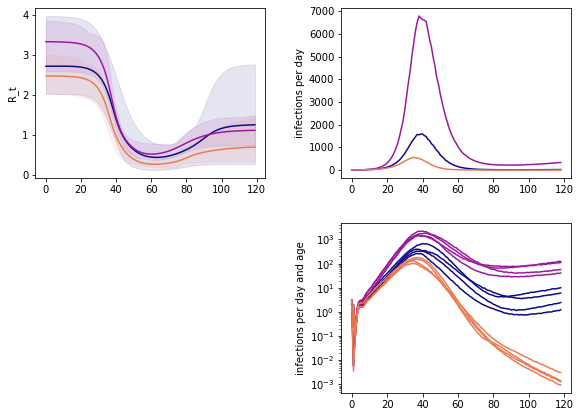

In [66]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.05,right=0.98,top=0.94,bottom=0.05)
plasma = plt.cm.plasma
gs = fig.add_gridspec(2,2)

ax = fig.add_subplot(gs[0,1])
bx = fig.add_subplot(gs[1,1])

dx = fig.add_subplot(gs[0,0])

for i,c in enumerate(tf.transpose(infected_T,perm=[1,2,0])):
    color = plasma(i/infected_T.shape[1])
    x = np.zeros(infected_T.shape[0]-1)
    for a in c:
        x2 = np.diff(a)
        bx.semilogy(x2,color=color)
        x += x2
#    ax.semilogy(x,"-",color=color)
    ax.plot(x,"-",color=color)
    
for i,r in enumerate(tf.transpose(R_T,perm=[1,2,0])):
    color = plasma(i/R_T.shape[1])
    dx.plot(np.mean(r,axis=0),color=color)
    dx.fill_between(range(R_T.shape[0]),*(np.min(r,axis=0),np.max(r,axis=0)),color=color,alpha=.1)

ax.set_ylabel("infections per day")
bx.set_ylabel("infections per day and age")
dx.set_ylabel("R_t")